In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from time import time
from pathlib import Path
import sys, os

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
import seaborn as sns
from utils4t import MultipleTimeSeriesCV, format_time

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

sns.set_style('whitegrid')
np.random.seed(42)
size = 15
lookahead = 1

results_path = Path('results', 'cnn_for_trading')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


In [3]:
# Load Model Data
with pd.HDFStore('data/universe_data.h5') as store:
    features = store['img_data']
    targets = store['targets']
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2416051 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2018-03-27 00:00:00'))
Columns: 225 entries, 01_CMO to 11_WMA
dtypes: float32(195), float64(30)
memory usage: 2.3+ GB


In [5]:
features.head(10)

01_CMO    01_ROC   01_NATR    01_PPO   01_MACD  \
symbol date                                                            
A      2001-01-02 -34.412796 -0.973141  6.947728  0.585962  0.534434   
       2001-01-03  12.697194  2.633023  7.902791  1.489047  0.594177   
       2001-01-04  25.371769  8.878505  7.599194  2.874703  0.748755   
       2001-01-05  -0.667682 -1.573114  8.137382  2.481612  0.687998   
       2001-01-08 -12.974548 -3.724462  8.088328  1.464707  0.534037   
       2001-01-09 -14.725676 -3.196347  7.756344  0.662250  0.393383   
       2001-01-10   6.201897  8.706761  7.151905  1.021115  0.403544   
       2001-01-11  22.686089  2.547657  6.885161  2.109057  0.528496   
       2001-01-12   8.185741 -3.639485  6.569717  2.223989  0.542454   
       2001-01-16  23.762115  5.684708  6.123020  3.042057  0.658498   

                     01_CMA    01_RMW    01_HML  01_Market    01_SMB  ...  \
symbol date                                                           ...   
A      2001-01-02  0.025279 -0.006478 -0.016951   0.013758 -0.011674  ...   
       2001-01-03  0.014975 -0.008856 -0.018188   0.009819 -0.020037  ...   
       2001-01-04  0.005857 -0.002693 -0.021231   0.004036 -0.009937  ...   
       2001-01-05  0.000882 -0.003614 -0.013796   0.005879 -0.005555  ...   
       2001-01-08 -0.019798 -0.003292  0.017045   0.014734  0.015989  ...   
       2001-01-09 -0.057114 -0.016250  0.077492   0.023451  0.046154  ...   
       2001-01-10 -0.080198 -0.032393  0.107490   0.018679  0.061976  ...   
       2001-01-11 -0.035940 -0.019112  0.033739   0.005908  0.027541  ...   
       2001-01-12 -0.033253 -0.013577  0.029525   0.008077  0.021867  ...   
       2001-01-16 -0.021099  0.001203  0.010575   0.012431  0.019688  ...   

                     11_CMA    11_RMW    11_HML  11_Market    11_SMB  \
symbol date                                                            
A      2001-01-02 -0.000318  0.001430 -0.002984   0.017752  0.008332   
       2001-01-03  0.000321  0.002027 -0.004751   0.017179  0.006739   
       2001-01-04 -0.000894  0.002713 -0.006307   0.016025  0.010261   
       2001-01-05 -0.001228  0.001167 -0.004730   0.016212  0.009304   
       2001-01-08  0.000942  0.001341 -0.005059   0.017432  0.010896   
       2001-01-09  0.003383  0.003184 -0.008622   0.017611  0.009998   
       2001-01-10  0.002964  0.002954 -0.008293   0.017326  0.009965   
       2001-01-11  0.002584  0.002016 -0.007086   0.017121  0.009000   
       2001-01-12  0.002168  0.002470 -0.006528   0.017463  0.007894   
       2001-01-16  0.002428  0.002848 -0.007988   0.016461  0.007431   

                     11_BBH    11_BBL     11_RSI     11_EMA     11_WMA  
symbol date                                                             
A      2001-01-02  0.151378  0.004491  46.341988  36.953236  37.318766  
       2001-01-03  0.066146  0.090595  54.497822  37.110993  37.350420  
       2001-01-04  0.034141  0.120748  57.293777  37.420349  37.568837  
       2001-01-05  0.080985  0.075976  52.150497  37.437270  37.528706  
       2001-01-08  0.102645  0.049909  49.463108  37.306922  37.354283  
       2001-01-09  0.095221  0.044919  49.090408  37.171844  37.184575  
       2001-01-10  0.055356  0.081671  52.609795  37.238066  37.231630  
       2001-01-11  0.020442  0.114962  55.785439  37.477090  37.467154  
       2001-01-12  0.041336  0.093935  53.361328  37.573217  37.585091  
       2001-01-16  0.016178  0.120144  56.280544  37.823378  37.873037  

[10 rows x 225 columns]

In [8]:
targets.head(10)

r01_fwd  r01dec_fwd   r05_fwd  r05dec_fwd
symbol date                                                  
A      2001-01-02  0.103184         7.0  0.041667         6.0
       2001-01-03  0.037769         8.0 -0.014609         5.0
       2001-01-04 -0.054764         2.0 -0.011845         4.0
       2001-01-05 -0.032873         1.0  0.019433         5.0
       2001-01-08 -0.004695         4.0  0.092770         7.0
       2001-01-09  0.043585         8.0  0.168679         8.0
       2001-01-10  0.040680         7.0  0.221479         9.0
       2001-01-11 -0.024844         2.0  0.138985         9.0
       2001-01-12  0.036701         8.0  0.117940         9.0
       2001-01-16  0.064444         9.0  0.078364         7.0

In [4]:
features = features[:int(len(features)/2)]
targets = targets[:int(len(targets)/2)]

features.shape, targets.shape

((1208025, 225), (1208025, 4))

In [5]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1208025 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('JNPR', Timestamp('2012-08-14 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   r01_fwd     1207668 non-null  float64
 1   r01dec_fwd  1207667 non-null  float64
 2   r05_fwd     1206240 non-null  float64
 3   r05dec_fwd  1206240 non-null  float64
dtypes: float64(4)
memory usage: 41.7+ MB


In [6]:
outcome = f'r{lookahead:02}_fwd'
features = features.join(targets[[outcome]]).dropna()
target = features[outcome]
features = features.drop(outcome, axis=1)

In [7]:
# CNN
def make_model(filter1=16, act1='relu', filter2=32, act2='relu', do1=.25, do2=.5, dense=32):
    input_shape = (size, size, 1)
    cnn = Sequential([
        Conv2D(filters=filter1, kernel_size=3, padding='same', activation=act1, input_shape=input_shape,
               name='CONV1'),
        Conv2D(filters=filter2, kernel_size=3, padding='same', activation=act2, name='CONV2'),
        MaxPooling2D(pool_size=2, name='POOL2'),
        Dropout(do1, name='DROP1'),
        Flatten(name='FLAT1'),
        Dense(dense, activation='relu', name='FC1'),
        Dropout(do2, name='DROP2'),
        Dense(1, activation='linear', name='FC2')
    ])
    cnn.compile(loss='mse',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                                  nesterov=False, name='SGD'),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return cnn

cnn = make_model()
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 15, 15, 16)        160       
                                                                 
 CONV2 (Conv2D)              (None, 15, 15, 32)        4640      
                                                                 
 POOL2 (MaxPooling2D)        (None, 7, 7, 32)          0         
                                                                 
 DROP1 (Dropout)             (None, 7, 7, 32)          0         
                                                                 
 FLAT1 (Flatten)             (None, 1568)              0         
                                                                 
 FC1 (Dense)                 (None, 32)                50208     
                                                                 
 DROP2 (Dropout)             (None, 32)                0

In [8]:
# Train the Model
train_period_length = 5 * 12 * 21
test_period_length = 5 * 21
n_splits = 16
cv = MultipleTimeSeriesCV(n_splits=n_splits, train_period_length=train_period_length,
                          test_period_length=test_period_length, lookahead=lookahead)

def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    return (x_train.reshape(-1, size, size, 1), y_train, x_val.reshape(-1, size, size, 1), y_val)

In [9]:
batch_size = 64
checkpoint_path = results_path / f'lookahead_{lookahead:02d}'
if not checkpoint_path.exists():
    checkpoint_path.mkdir(parents=True, exist_ok=True)

start = time()
ic  = []
epoch = 10

for fold, (train_idx, test_idx) in enumerate(cv.split(features)):
    X_train, y_train, X_val, y_val = get_train_valid_data(features, target, train_idx, test_idx)
    preds = y_val.to_frame('actual')
    r = pd.DataFrame(index=y_val.index.unique(level='date')).sort_index()
    model = make_model(filter1=16, act1='relu', filter2=32, act2='relu', do1=.25, do2=.5, dense=32)
    best_mean = best_median = -np.inf

    model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val),
              epochs=epoch, shuffle=True, workers=6)
    model.save_weights((checkpoint_path / f'ckpt_{fold}').as_posix())
    preds[epoch] = model.predict(X_val).squeeze()
    r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
    print(f'{format_time(time()-start)} | fold:{fold + 1:02d} | Mean:{r[epoch].mean():7.4f} | Median:{r[epoch].median():7.4f}')

    # source code has been changed simply because of the memory problem
    # for epoch in range(20):
    #     model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val),
    #               epochs=epoch + 1, initial_epoch=epoch, verbose=0, shuffle=True, workers=6)
    #     model.save_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
    #     preds[epoch] = model.predict(X_val).squeeze()
    #     r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
    #     print(f'{format_time(time()-start)} | fold:{fold + 1:02d} | epoch:{epoch + 1:02d} | Mean:{r[epoch].mean():7.4f} | Median:{r[epoch].median():7.4f}')
    ic.append(r.assign(fold=fold))
    
    if fold > 10:
        break

ic = pd.concat(ic)
ic.to_csv(checkpoint_path / 'ic.csv')

Epoch 1/10
5331/5331 [==============================] - 26s 3ms/step - loss: 3.9476e-04 - rmse: 0.0199 - val_loss: 3.7491e-04 - val_rmse: 0.0194
Epoch 2/10
5331/5331 [==============================] - 17s 3ms/step - loss: 3.6020e-04 - rmse: 0.0190 - val_loss: 3.7463e-04 - val_rmse: 0.0194
Epoch 3/10
5331/5331 [==============================] - 17s 3ms/step - loss: 3.5943e-04 - rmse: 0.0190 - val_loss: 3.7412e-04 - val_rmse: 0.0193
Epoch 4/10
5331/5331 [==============================] - 17s 3ms/step - loss: 3.5934e-04 - rmse: 0.0190 - val_loss: 3.7427e-04 - val_rmse: 0.0193
Epoch 5/10
5331/5331 [==============================] - 17s 3ms/step - loss: 3.5922e-04 - rmse: 0.0190 - val_loss: 3.7461e-04 - val_rmse: 0.0194
Epoch 6/10
5331/5331 [==============================] - 17s 3ms/step - loss: 3.5908e-04 - rmse: 0.0189 - val_loss: 3.7411e-04 - val_rmse: 0.0193
Epoch 7/10
5331/5331 [==============================] - 17s 3ms/step - loss: 3.5876e-04 - rmse: 0.0189 - val_loss: 3.7411e-04 - va

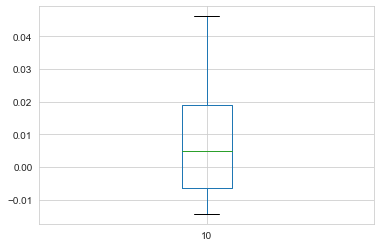

In [10]:
# Evaluate results
ic.groupby('fold').mean().boxplot();

In [180]:
ic.groupby('fold').mean()

,10
fold,
0,-0.014330
1,-0.006414
2,-0.013591
3,0.015334
4,0.029792
5,-0.006340
6,0.046164
7,0.018540
8,0.001946


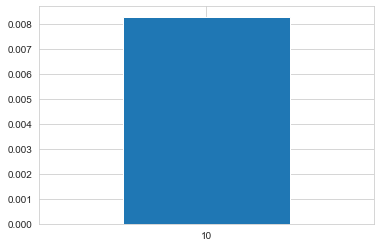

In [11]:
ic.groupby('fold').mean().mean().sort_index().plot.bar(rot=0);

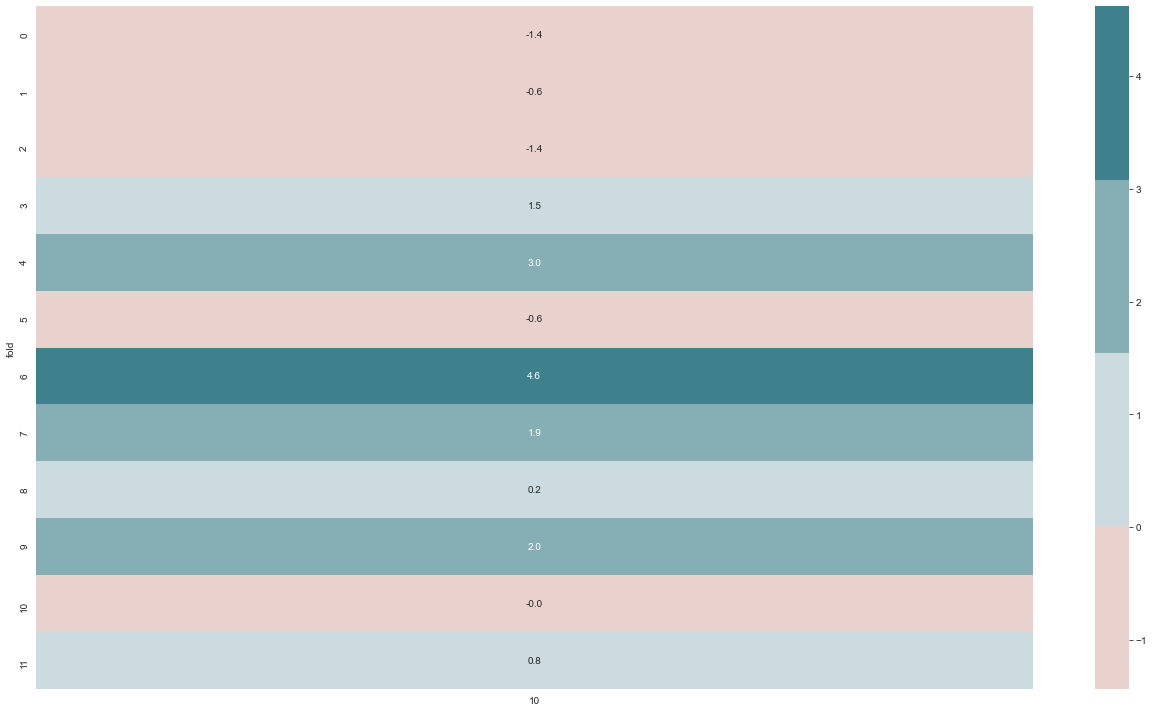

In [15]:
cmap = sns.diverging_palette(h_neg=20, h_pos=210)
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(ic.groupby('fold').mean().mul(100), ax=ax, center=0, cmap=cmap, annot=True, fmt='.1f')
fig.tight_layout()

In [14]:
# Make Predictions
# def generate_predictions(epoch):
def generate_predictions():
    predictions = []
    for fold, (train_idx, test_idx) in enumerate(cv.split(features)):
        if fold == 12:
            break
        X_train, y_train, X_val, y_val = get_train_valid_data(features, target, train_idx, test_idx)
        preds = y_val.to_frame('actual')
        model = make_model(filter1=16, act1='relu', filter2=32, act2='relu', do1=.25, do2=.5, dense=32)
        # status = model.load_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
        status = model.load_weights((checkpoint_path / f'ckpt_{fold}').as_posix())
        status.expect_partial()
        predictions.append(pd.Series(model.predict(X_val).squeeze(), index=y_val.index))
    return pd.concat(predictions)

preds = {}
for i in enumerate(ic.drop('fold', axis=1).mean().nlargest(3).index):
    preds[i] = generate_predictions()
with pd.HDFStore(results_path / 'predictions.h5') as store:
    store.put('predictions', pd.DataFrame(preds).sort_index())

In [179]:
df_predictions = pd.DataFrame(preds)
df_predictions.columns = ['prediction']
df_predictions = df_predictions.swaplevel().unstack()
df_predictions.sort_values(by='date', ascending=True)

prediction                                                    \
symbol              A       AAL       AAP      AAPL      ABBV       ABC   
date                                                                      
2013-03-25  -0.001340 -0.001364 -0.001362 -0.001363       NaN -0.001370   
2013-03-26  -0.001348 -0.001364 -0.001367 -0.001359       NaN -0.001372   
2013-03-27  -0.001349 -0.001364 -0.001365 -0.001343       NaN -0.001372   
2013-03-28  -0.001349 -0.001370 -0.001373 -0.001336       NaN -0.001382   
2013-04-01  -0.001343 -0.001362 -0.001365 -0.001332       NaN -0.001384   
...               ...       ...       ...       ...       ...       ...   
2018-03-20   0.000157  0.000152  0.000155  0.000167  0.000146  0.000152   
2018-03-21   0.000168  0.000156  0.000149  0.000173  0.000154  0.000154   
2018-03-22   0.000164  0.000152  0.000148  0.000178  0.000130  0.000153   
2018-03-23   0.000168  0.000153  0.000145  0.000187  0.000136  0.000166   
2018-03-26   0.000171  0.000158  0.000141  0.000177  0.000156  0.000178   

                                                    ...                      \
symbol           ABT       ACE       ACI       ACN  ...       ITW       IVZ   
date                                                ...                       
2013-03-25 -0.001346 -0.001361 -0.001355 -0.001337  ... -0.001344 -0.001347   
2013-03-26 -0.001355 -0.001364 -0.001356 -0.001341  ... -0.001344 -0.001358   
2013-03-27 -0.001360 -0.001364 -0.001360 -0.001343  ... -0.001342 -0.001354   
2013-03-28 -0.001366 -0.001368 -0.001346 -0.001351  ... -0.001345 -0.001358   
2013-04-01 -0.001366 -0.001364 -0.001337 -0.001349  ... -0.001345 -0.001344   
...              ...       ...       ...       ...  ...       ...       ...   
2018-03-20  0.000135       NaN       NaN  0.000131  ...  0.000130  0.000138   
2018-03-21  0.000142       NaN       NaN  0.000136  ...  0.000129  0.000137   
2018-03-22  0.000178       NaN       NaN  0.000156  ...  0.000150  0.000138   
2018-03-23  0.000166       NaN       NaN  0.000167  ...  0.000153  0.000141   
2018-03-26  0.000159       NaN       NaN  0.000166  ...  0.000163  0.000133   

                                                                        \
symbol          JBHT       JBL      JBLU       JCI       JCP      JDSU   
date                                                                     
2013-03-25 -0.001355 -0.001332 -0.001362 -0.001345 -0.001331 -0.001354   
2013-03-26 -0.001355 -0.001331 -0.001359 -0.001347 -0.001332 -0.001354   
2013-03-27 -0.001355 -0.001332 -0.001363 -0.001346 -0.001333 -0.001354   
2013-03-28 -0.001361 -0.001336 -0.001362 -0.001359 -0.001332 -0.001355   
2013-04-01 -0.001347 -0.001332 -0.001346 -0.001353 -0.001332 -0.001351   
...              ...       ...       ...       ...       ...       ...   
2018-03-20  0.000143       NaN  0.000133  0.000166  0.000206       NaN   
2018-03-21  0.000142       NaN  0.000152  0.000180  0.000208       NaN   
2018-03-22  0.000156       NaN  0.000151  0.000165  0.000210       NaN   
2018-03-23  0.000163       NaN  0.000150  0.000168  0.000191       NaN   
2018-03-26  0.000152       NaN  0.000158  0.000162  0.000196       NaN   

                                
symbol           JEC       JNJ  
date                            
2013-03-25 -0.001382 -0.001374  
2013-03-26 -0.001393 -0.001389  
2013-03-27 -0.001395 -0.001392  
2013-03-28 -0.001398 -0.001395  
2013-04-01 -0.001367 -0.001397  
...              ...       ...  
2018-03-20       NaN  0.000177  
2018-03-21       NaN  0.000178  
2018-03-22       NaN  0.000169  
2018-03-23       NaN  0.000169  
2018-03-26       NaN  0.000189  

[1260 rows x 294 columns]